In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF 그래프
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델
import pmdarima as pm # Auto ARIMA

In [68]:
ap = pd.read_csv('../../data/AirPassengers.csv')

In [69]:
# Month 정보는 모델링에 불필요하므로 제거
ap.drop('Month', axis=1, inplace=True)

# passengers 컬럼도 다루기 쉽게 이름 변경
ap.rename({'#Passengers':'passengers'}, axis=1, inplace=True)

In [70]:
 ap.head()

,passengers
0,112
1,118
2,132
3,129
4,121


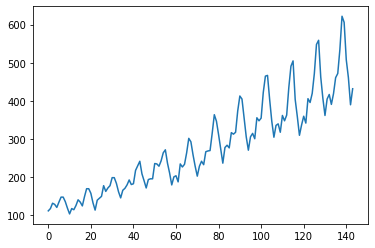

In [71]:
# 데이터 시각화
plt.plot(ap)
plt.show()

### 분산 일정하게 만들기

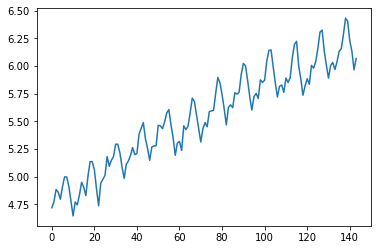

In [72]:
# Log Transformation 통해 variance 일정하게 만들기
ap_log = np.log(ap)
plt.plot(ap_log)
plt.show()

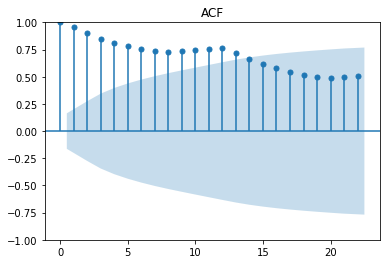

In [73]:
plot_acf(ap_log)
plt.title('ACF')
plt.show()

- 점차감소하는 모습을 보이며, lag가 10이 넘어가면서부터는 유의미한 자기상관이 없어지는 모습을 보임

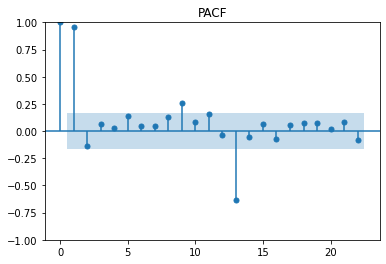

In [74]:
plot_pacf(ap_log)
plt.title('PACF')
plt.show()

- lag가 0, 1, 13 정도에서 유의미한 자기상관을 보임

- acf, pacf는 ap_log가 계속 증가하는 모습을 보이고 있기에 그런 것으로 보임

### 추세 제거

In [75]:
# 1차 차분 수행
ap_diff = ap_log.diff(1)
ap_diff.dropna(inplace=True)

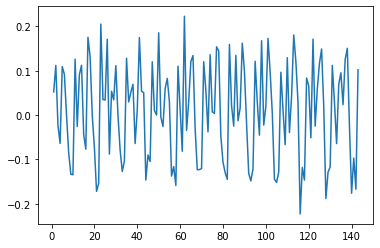

In [76]:
# 분산, 추세 작업 후 그래프 시각화
plt.plot(ap_diff)
plt.show()

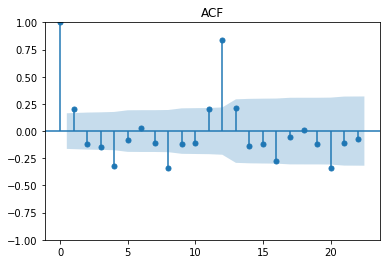

In [77]:
plot_acf(ap_diff)
plt.title('ACF')
plt.show()

- lag가 0, 12에서 유의미한 자기상관을 보임

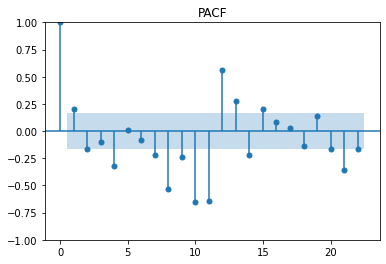

In [78]:
plot_pacf(ap_diff)
plt.title('PACF')
plt.show()

- lag가 0, 8, 10, 11, 12 등에서 유의미한 상관을 보임

- lag12일 때 중복으로 유의미한 자기상관 나타남 => 계절성 의심 가능

### Auto ARIMA

In [79]:
ap_log.head()

,passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791


In [80]:
# train, test 분리
train_size = int(ap_log.shape[0]*0.8)
ap_log_train = ap_log.iloc[:train_size]
ap_log_test = ap_log.iloc[train_size:]

In [81]:
# AutoARIMA 모델 생성 및 학습
model = pm.AutoARIMA(seasonal=True, suppress_warnings=True, trace=True, max_D=12, m=12) # 위에서 계절성이 나타난 것으로 보이므로 seasonal=True
res = model.fit(ap_log_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-371.448, Time=2.91 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=1.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.06 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-375.742, Time=2.57 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-348.802, Time=1.00 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-373.720, Time=6.51 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-367.480, Time=2.54 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-371.629, Time=5.18 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-376.939, Time=2.27 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-348.813, Time=0.85 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-372.083, Time=2.20 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-374.916, Time=4.11 sec
 ARIMA(1,0,2)(1,1,0

- AIC값이 -378.954로 가장 낮은 ARIMA(2,0,0)(0,1,1)[12] intercept 모델이 가장 적합하다는 결과가 나옴
- Total fit time은 약 82초가 소요된 것으로 나왔고, 각 모델의 학습에 걸린 시간 Time은 각각 다르나 큰 차이는 없어보이며 Best model 역시 2.74로 학습에 많은 시간이 소요되지 않아 모델 선정에 제약이 없어보임
- Best model의 p값이 2인 것으로 보아 t-2 시점까지의 값이 현재 데이터에 영향을 주고, d값이 0인 것으로 보아 차분은 진행하지 않으며, q값이 0인 것으로 보아 과거의 오차가 현재에 영향을 주지 않는 모델임을 알 수 있음. 또한, p, q, d 값이 모두 2 이하로 안정적인 모델이 될 수 있을 것으로 생각해볼 수 있음.
- s값이 12인 것으로 보아 월별 데이터 기준이므로 1년 단위의 주기가 나타나는 것을 알 수 있음. P값이 0인 것으로 보아 계절 자기회귀는 없고, D값이 1인 것으로 보아 계절 차분 1회를 적용하며, Q값이 1인 것으로 보아 1년 전 오차가 현재 데이터에 영향을 주는 모델임을 알 수 있음.

In [82]:
# 예측 결과 도출
preds, conf_int = res.predict(n_periods=ap_log_test.shape[0], return_conf_int=True)

In [83]:
conf_int.shape[0]

29

In [84]:
len(x_axis[-preds.shape[0]:])

29

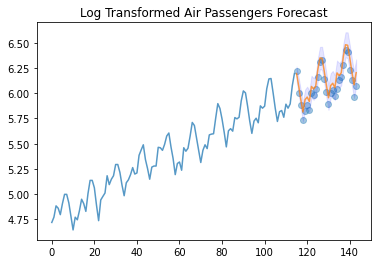

In [85]:
# 그래프로 ARIMA 모델이 실제와 얼마나 잘 맞는지 확인
x_axis = np.arange(ap_log_train.shape[0] + preds.shape[0])

plt.plot(x_axis[:ap_log_train.shape[0]], ap_log_train, alpha=0.75)
plt.plot(x_axis[ap_log_train.shape[0]:], preds, alpha=0.75) # 예측 데이터
plt.scatter(x_axis[ap_log_train.shape[0]:], ap_log_test, alpha=0.4, marker='o') # 기존 데이터
plt.fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b') # 예측값의 95% 신뢰구간
plt.title('Log Transformed Air Passengers Forecast')
plt.show()

### ARCH

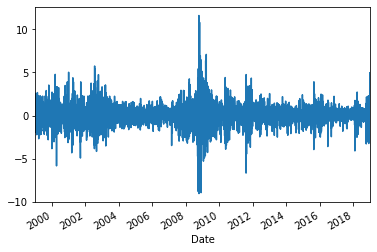

In [86]:
import datetime as dt
import arch.data.sp500

st = dt.datetime(2002, 1, 1)
en = dt.datetime(2022, 1, 1)
data = arch.data.sp500.load()
market = data['Adj Close'] # 종가만 추출
returns = 100 * market.pct_change().dropna() # 수익률 계산
ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())
plt.show()

- 수익률의 변동을 보면 변동이 큰 경우끼리 몰려있고 변동이 작은 경우끼리 몰려있음을 확인할 수 있음 => 조건부 이분산성을 확인할 수 있음

In [87]:
from arch import arch_model

am = arch_model(returns) # 수익률 데이터 모델에 적합
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Thu, Sep 11 2025   Df Residuals:                     5029
Time:         

- 변동성 모델 Volatility Model에서 alpha[1], beta[1] 을 통해 GARCH(1,1)임을 확인할 수 있음. omega, alpha, beta 값은 각각 0.0175, 0.1022, 0.8852이며 alpha값에 비해 beta값이 큰 것으로 보아 직전 시점의 오차 제곱보다 직전 시점의 분산이 현재 시점의 분산에 더 큰 영향을 준다는 것을 알 수 있음. p값의 경우 모두 0.01보다 작아 99% 유의수준에서 유의미한 값을 나타낸다고 할 수 있음.

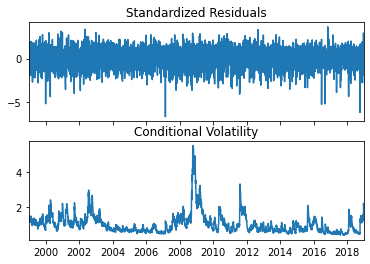

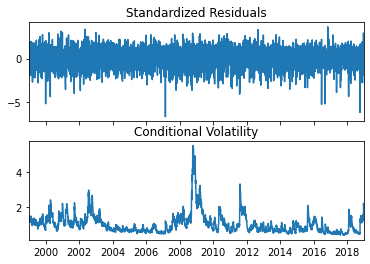

In [88]:
res.plot()

- Standardized Residuals에 뚜렷한 시계열 패턴이나 변동성 클러스터링이 관찰되지 않는 것으로 보아 모델이 데이터의 변동성을 어느정도 잘 설명했다고 볼 수 있음. Conditional Volatility에서 변동성의 패턴이 실제 수익률 변동성과 유사한 패턴이 나온 것을 확인할 수 있음. 특히 2009년의 큰 변동이 반영된 것을 확인할 수 있음.